# Kevin Tong - Bird Image Classification

# Packages

In [1]:
import datetime
import time
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as z
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
import os
import cv2
from PIL import Image
from tensorflow.keras.regularizers import l2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Northwestern MSDS/MSDS 458/458_Final_Notebooks/spectrogram_output'

# Preprocessing

In [3]:
# Initialize a set to store unique classes (bird species)
unique_classes = set()

# Define a function to load and preprocess images
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path)
        img = img.resize((224, 224))  # Resize to your desired dimensions
        img = img.convert("RGB")  # Convert to RGB (remove alpha channel if present)
        img = np.array(img) / 255.0   # Normalize pixel values
        images.append(img)
    return np.array(images)

# Loop through directories and load images
all_images = []
for bird_folder in os.listdir(data_dir):
    bird_folder_path = os.path.join(data_dir, bird_folder)
    if os.path.isdir(bird_folder_path) and len(os.listdir(bird_folder_path)) > 1:
        # Add the current folder name to the set of unique classes
        unique_classes.add(bird_folder)

        image_paths = [os.path.join(bird_folder_path, img) for img in os.listdir(bird_folder_path)]
        images = load_and_preprocess_images(image_paths)
        all_images.extend(images)

all_images = np.array(all_images)

# Calculate the total number of classes
num_classes = len(unique_classes)
print("Number of classes:", num_classes)

Number of classes: 110


In [4]:
# Load and preprocess labels
all_labels = []
for bird_folder in os.listdir(data_dir):
    bird_folder_path = os.path.join(data_dir, bird_folder)
    if os.path.isdir(bird_folder_path) and len(os.listdir(bird_folder_path)) > 1:
        label = bird_folder  # Assuming folder name is the label
        labels = [label] * len(os.listdir(bird_folder_path))
        all_labels.extend(labels)

# Convert labels to numerical format (e.g., one-hot encoding)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and temporary set (which includes validation and test data)
train_images, temp_images, train_labels, temp_labels = train_test_split(all_images, encoded_labels, test_size=0.2, random_state=42)

# Split temporary set into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)


In [6]:
print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (1725, 224, 224, 3)
Validation images shape: (216, 224, 224, 3)
Test images shape: (216, 224, 224, 3)


# Neural Network

In [7]:
start_time = time.time()

# Define your CNN model with Conv2D and Dropout layers
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Add dropout layers
    layers.Dropout(0.5),  # Add dropout after flattening
    layers.Dense(128, activation='relu'),

    layers.Dropout(0.5),  # Add dropout after the first dense layer
    layers.Dense(num_classes, activation='softmax')  # num_classes is the number of bird species
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [9]:
# Train the model
history = model.fit(train_images, train_labels, epochs=200, batch_size=64,
                    validation_data=(val_images, val_labels),callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/200
27/27 [==============================] - 18s 156ms/step - loss: 4.6913 - accuracy: 0.0145 - val_loss: 4.6487 - val_accuracy: 0.0324
Epoch 2/200
27/27 [==============================] - 2s 62ms/step - loss: 4.6177 - accuracy: 0.0133 - val_loss: 4.5444 - val_accuracy: 0.0139
Epoch 3/200
27/27 [==============================] - 4s 151ms/step - loss: 4.4737 - accuracy: 0.0325 - val_loss: 4.3045 - val_accuracy: 0.0602
Epoch 4/200
27/27 [==============================] - 2s 70ms/step - loss: 4.1528 - accuracy: 0.0928 - val_loss: 3.8162 - val_accuracy: 0.2083
Epoch 5/200
27/27 [==============================] - 3s 118ms/step - loss: 3.6801 - accuracy: 0.1872 - val_loss: 3.4227 - val_accuracy: 0.2963
Epoch 6/200
27/27 [==============================] - 2s 76ms/step - loss: 3.1922 - accuracy: 0.2812 - val_loss: 2.9093 - val_accuracy: 0.3981
Epoch 7/200
27/27 [==============================] - 3s 110ms/step - loss: 2.7910 - accuracy: 0.3530 - val_loss: 2.6384 - val_accuracy: 0.4537
E

In [10]:
end_time = time.time()
runtime = end_time - start_time
print('Total runtime:', runtime, 'seconds')

Total runtime: 90.39768433570862 seconds


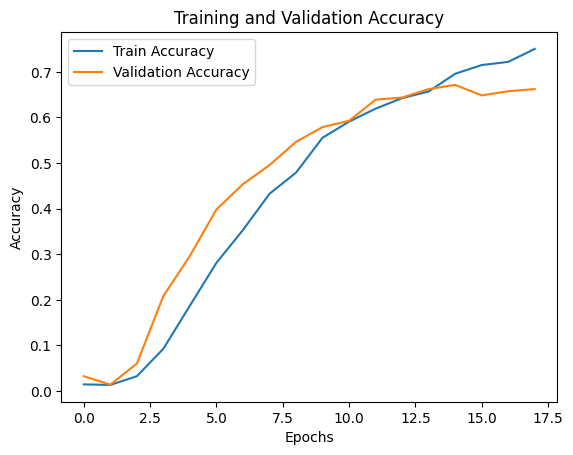

In [11]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

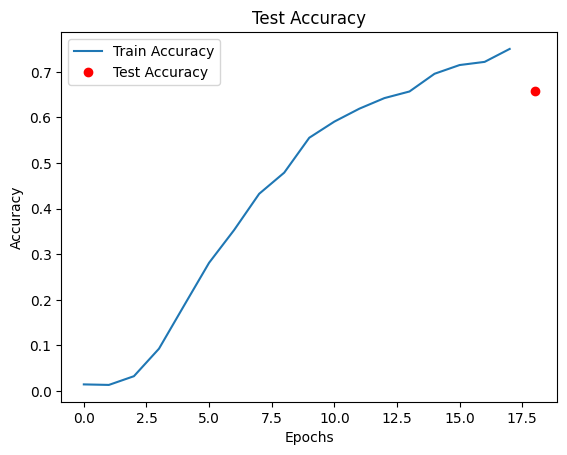

In [12]:
# Plot test accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(len(history.history['val_accuracy']), test_acc, 'ro', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()